# Entrenamiento de una Red Neoronal (Perceptron)

```
Autor       : Francisco Jimenez Mucho
Linkedin    : https://www.linkedin.com/in/fjmucho/
date        : Julio 2023, uppdate julio 2024
```

## Viga simplemente apoyada

In [121]:
import numpy as np, pandas as pd

from matplotlib import pyplot as plt

In [122]:
m = 1

cm = 0.01*m
kg = 1.0
kN = 1000.0*kg/m

### 1. Introduccion

En este ejemplo se requiere predecir la **deflexi√≥n m√°xima** de una viga **simplemente apoyada con carga puntual centrada**

$$\sigma_{m√°x} = \frac{P*L**3}{48*E*I}$$
donde:
- P: Carga puntual en el centro (kN)
- L:m Lognitud de la viga
- E: M√≥dulo de elasticidad
- I: Momento de inercia

Para solucionar usaremos 2 puntos de vista.
- Un **modelo de Machin Learning** (random forest Regresion)
- Formulacion cl√°sica o Modelo Matem√°tico de mec√°nica de materailes.

In [123]:
def gen_value_viga_simple(num_muestras = 10_000, random_sate=50):
    np.random.seed(random_sate)

    # M√≥dulos de elasticidad para diferentes resistencias a la compresi√≥n del hormig√≥n (fc) en MPa
    modulo_elasticidad = {
        175: 19_663_000,
        210: 21_541_000,
        280: 24_870_000,
        350: 27_805_000,
        420: 30_463_000,
    }
    claves_fc = list(modulo_elasticidad.keys())
    valores_E = list(modulo_elasticidad.values())

    # Longitudes entre 2 y 10 m, con incrementos de 0.05 m y ancho y altura entre 0.25 y 0.60 m y 0.30 y 1.00 m respectivamente
    longitud = np.round( np.random.uniform(2, 10, num_muestras)/0.05 ) * 0.05 # [m]
    ancho_b = np.round( np.random.uniform(0.25, 0.60, num_muestras)/0.05 ) * 0.05 # [m]
    altura_h = np.round( np.random.uniform(0.30, 1.00, num_muestras)/0.05 ) * 0.05 # [m]

    # Cargas aleatorias entre 10 y 100 kN
    cargasP = np.round(np.random.uniform(10, 100, num_muestras), 2) # [kN]

    idx_modulo_elasticidad = np.random.randint(0, len(valores_E), num_muestras)
    fc_values = [claves_fc[i] for i in idx_modulo_elasticidad]
    e_values = [valores_E[i] for i in idx_modulo_elasticidad]

    inercia_vals = (ancho_b * altura_h**3) / 12.0  # [m^4]

    idelta_vals = (cargasP*longitud**3) / (48 * np.array(e_values) * inercia_vals)

    data = pd.DataFrame({
        'L': longitud,  # [m]
        'b': ancho_b,  # [m]
        'h': altura_h,  # [m]
        'P': cargasP,  # [kN]
        'fc': fc_values,  # [MPa]
        'E': e_values,  # [MPa]
        "I": inercia_vals,  # [m^4]
        "deflexion_max_mm": idelta_vals*1000,  # [mm]
    })
    data.to_csv('outputs/parametros_viga_simplemente_apoyada.csv', index=True)

    return data

In [124]:
print("\nRectangular Beam\n")
print("   Width\n ________\n|        |\n|        |\n|        |\n|        | Depth\n|        |\n|        |\n|        |\n|________|\n")

print('\n\t\tP\t\t\n|_______________‚Üì_______________|\n|\t\tL\t\t|') # ‚Üì = \u2193


Rectangular Beam

   Width
 ________
|        |
|        |
|        |
|        | Depth
|        |
|        |
|        |
|________|


		P		
|_______________‚Üì_______________|
|		L		|


In [125]:
data = gen_value_viga_simple(10_000)
data.head(6)

L     b     h      P   fc         E         I  deflexion_max_mm
0  5.95  0.45  0.40  41.51  210  21541000  0.002400          3.523589
1  3.80  0.50  0.40  15.04  210  21541000  0.002667          0.299311
2  4.05  0.45  0.70  82.55  175  19663000  0.012863          0.451716
3  5.15  0.30  0.90  49.47  280  24870000  0.018225          0.310584
4  5.00  0.55  0.95  91.82  175  19663000  0.039296          0.309460
5  9.95  0.35  0.50  68.86  420  30463000  0.003646         12.724055

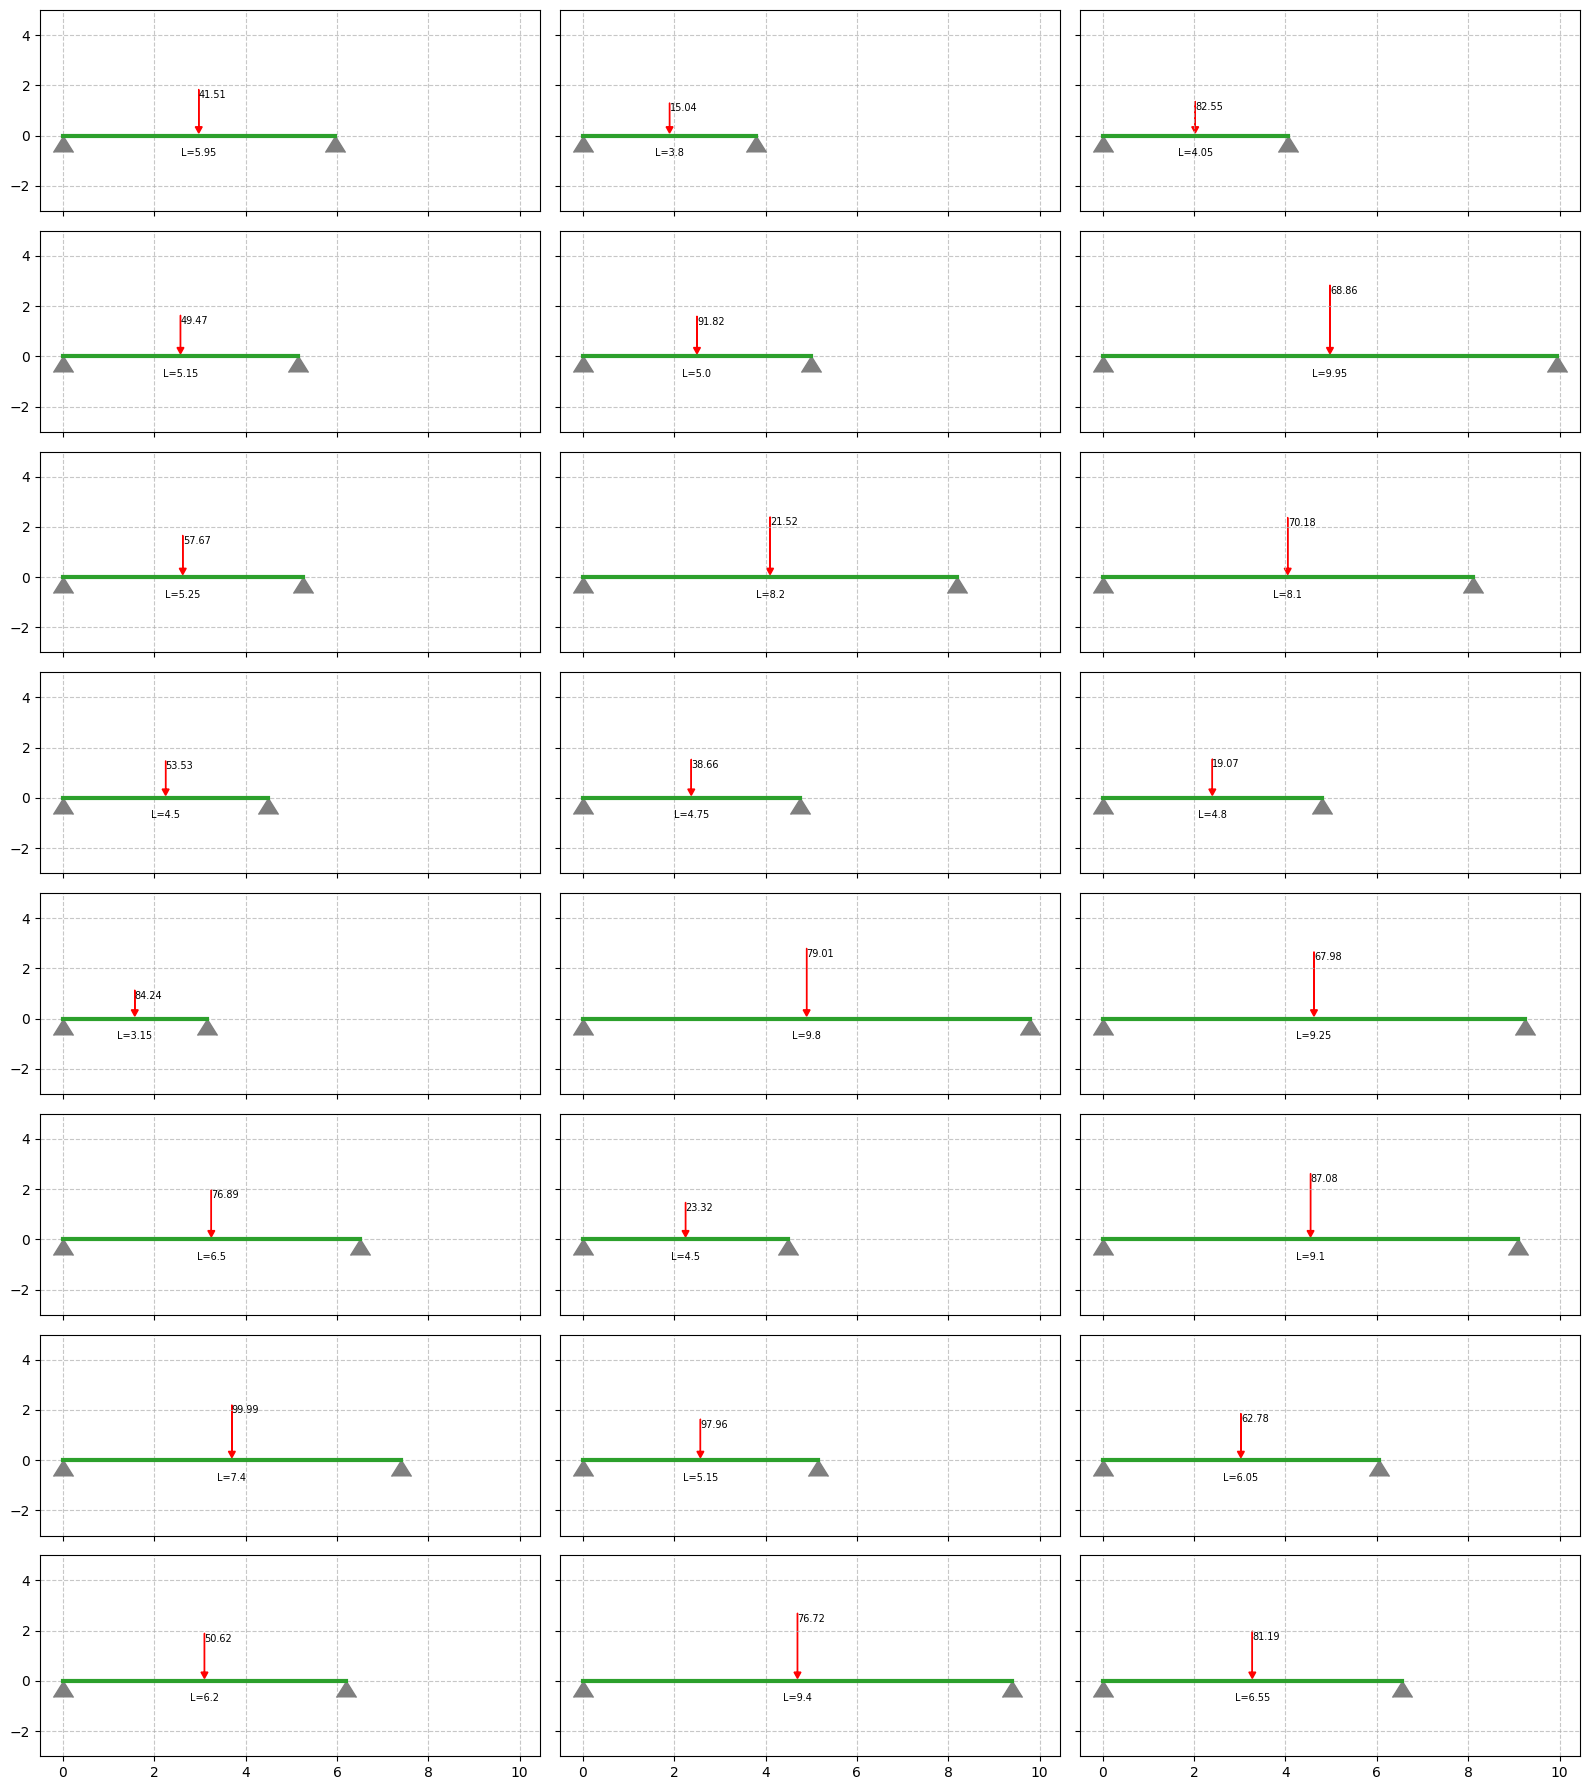

In [126]:
num_data = len(data['L'].head(24)) # debe ser multiplo de 3
fig, axes = plt.subplots(int(num_data/3), 3, figsize=(16, 18), sharex=True, sharey=True) # debe ser multiplo de 3 las filas y columnas
axs = axes.flatten() # lo convierte en una lista unidimensional
# fig.suptitle(f"Seccion de las vigas para {len(data)} muestras")
for i in range(num_data):
    L = data['L'][i].item()
    axs[i].plot([0, L], [0,0], marker=6, color='tab:gray', ms=15)   # restricciones
    axs[i].plot([0, L], [0,0], color='tab:green', lw=3)             # arista o viga
    axs[i].arrow(
        L/2,         # x: mitad de la viga
        0.35 + (L/4 + 0.0001),  # y: parte superior de la flecha
        0, -(L/4 + 0.0001), # dy NEGATIVO: apunta hacia abajo
        head_width=0.15,
        head_length=0.25,
        fc='red',
        ec='red'
    )
    axs[i].text( L/2, (L/4 + 0.01), str(round(data['P'][i].item(), 2)), ha='left', va='baseline', fontsize=7)
    axs[i].text(L/2, -0.5, 'L='+str(round(L,3)), color='k', ha='center', va='top', fontsize=7)
    # axs[i].axis('on')
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.7)
    axs[i].set_ylim([-3, 5])
plt.tight_layout()
plt.show()

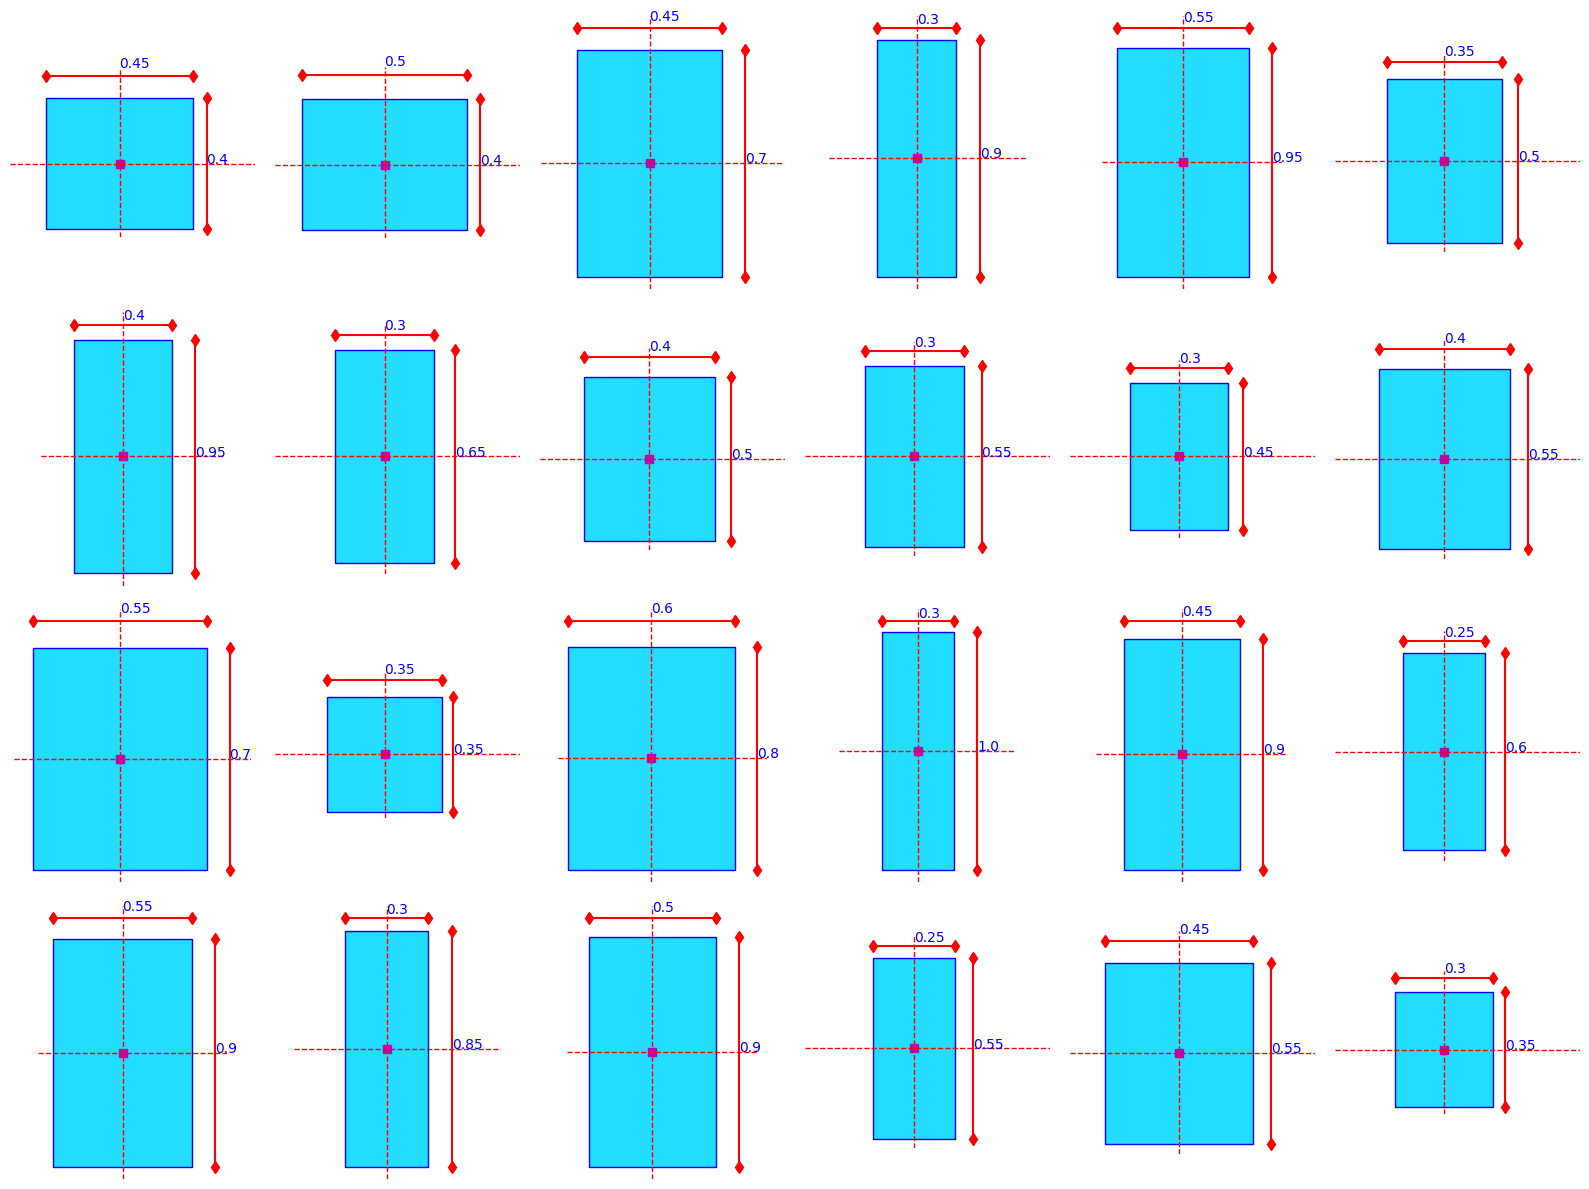

In [127]:
from func.seccionR import sec_rectangular

num_data = len(data['L'].head(24)) # debe ser multiplo de 6

fig, axes = plt.subplots(int(num_data/6), 6, figsize=(16, 12), sharex=True)
axs = axes.flatten() # lo convierte en una lista unidimensional
# fig.suptitle(f"Seccion de las vigas para {len(data)} muestras")

# sec_rectangular(axs[0], 2, 4, False)
for i in range(num_data):
    b = data['b'][i].item()
    h = data['h'][i].item()
    sec_rectangular(axs[i], round(b,2), round(h,2), False)
    axs[i].axis('scaled')
    # axs[i].set_ylabel("z")
    # axs[i].set_xlabel("y")
    
    axs[i].axis('off')
plt.box(False)
plt.tight_layout()
plt.show()

In [128]:
data.describe().round(2).transpose()

count         mean         std          min          25%  \
L                 10000.0         6.03        2.30         2.00         4.05   
b                 10000.0         0.42        0.10         0.25         0.35   
h                 10000.0         0.65        0.20         0.30         0.45   
P                 10000.0        54.87       26.00        10.00        32.25   
fc                10000.0       288.21       89.80       175.00       210.00   
E                 10000.0  24921241.30  3956829.99  19663000.00  21541000.00   
I                 10000.0         0.01        0.01         0.00         0.00   
deflexion_max_mm  10000.0         3.34        7.31         0.00         0.26   

                          50%          75%          max  
L                        6.05         8.00        10.00  
b                        0.40         0.50         0.60  
h                        0.65         0.80         1.00  
P                       55.06        77.38       100.00  
fc                     280.00       350.00       420.00  
E                 24870000.00  27805000.00  30463000.00  
I                        0.01         0.02         0.05  
deflexion_max_mm         0.92         3.04       111.05

In [129]:
data_keys = data.drop(columns=['E', 'I'], axis=1)
data_keys = data_keys.keys()
data_keys

Index(['L', 'b', 'h', 'P', 'fc', 'deflexion_max_mm'], dtype='object')

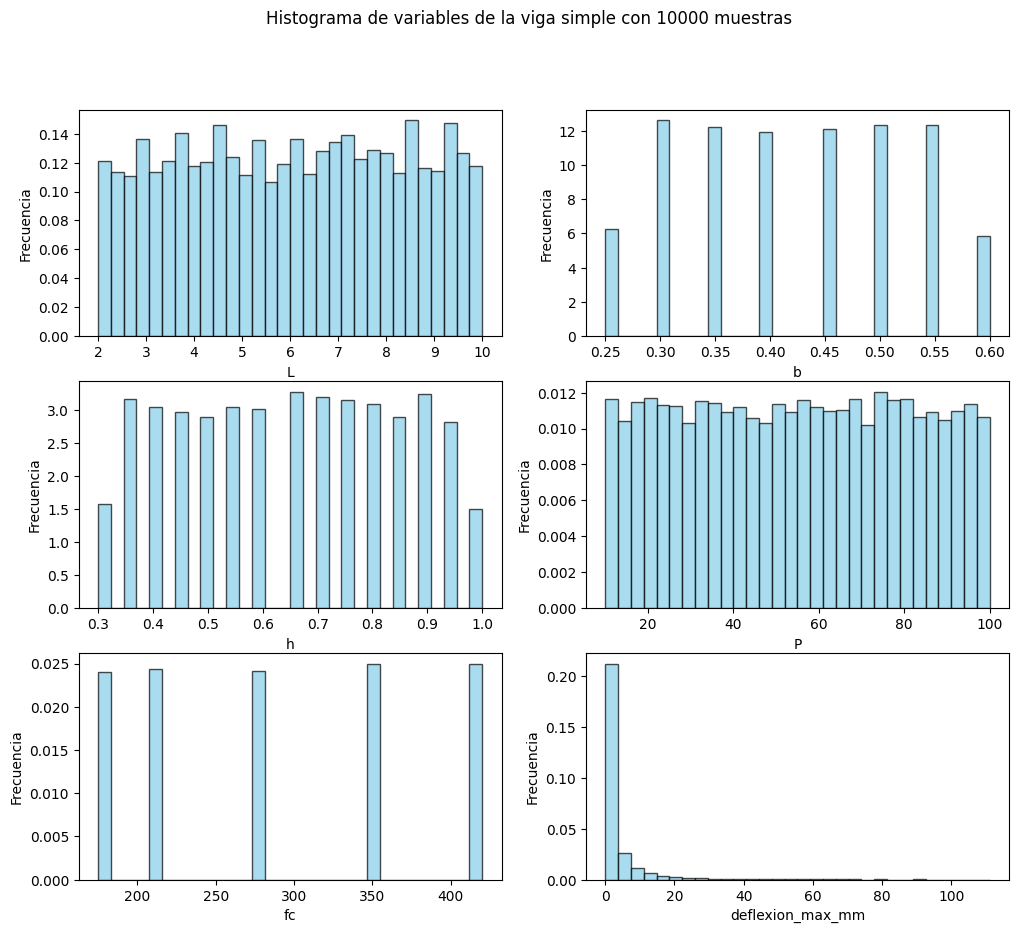

In [130]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10))
axs = ax.flatten() # lo convierte en una lista unidimensional
# print(axs)
fig.suptitle(f"Histograma de variables de la viga simple con {len(data)} muestras")

for i, var in enumerate(data_keys):
    axs[i].hist( data[var], bins=30, edgecolor='black', color="skyblue", density=True, alpha=0.7) # , kde=True
    # sns.histplot(data[column], kde=True, stat="count", bins=30, color='skyblue', edgecolor='black', ax=axes[i])
    # sns.kdeplot(data[column], color='red', ax=axes[i])
    axs[i].set_xlabel(var)
    axs[i].set_ylabel("Frecuencia")
plt.tight_layout
plt.show()

 Analisis univariado con Funci√≥n de densidad de probabilidad (PDF)  y Funciona de probabilidad¬†acumulada (CDF)

0       1           2       3
0   0.083443  0.9266    0.002363  0.9266
1   0.004241  0.0471   11.106989  0.9737
2   0.001279  0.0142   22.211616  0.9879
3   0.000585  0.0065   33.316242  0.9944
4   0.000171  0.0019   44.420868  0.9963
5   0.000153  0.0017   55.525494  0.9980
6   0.000072  0.0008   66.630121  0.9988
7   0.000045  0.0005   77.734747  0.9993
8   0.000045  0.0005   88.839373  0.9998
9   0.000018  0.0002   99.944000  1.0000
10       NaN     NaN  111.048626     NaN

Text(0.5, 0, 'deflexion_max_mm')

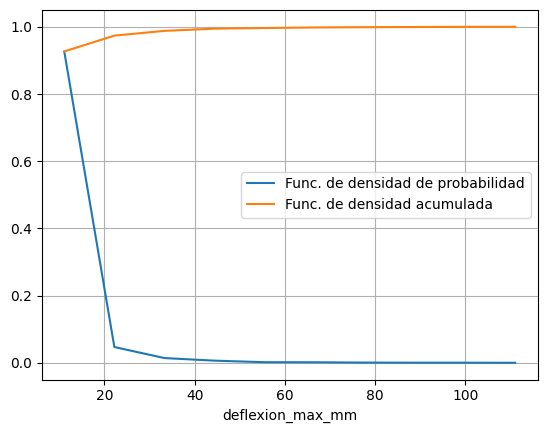

In [132]:
target_column = 'deflexion_max_mm'

counts, bin_edges = np.histogram(data[target_column],bins = 10, density = True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)

display( pd.DataFrame( [counts, pdf, bin_edges, cdf]).transpose() )

plt.plot(bin_edges[1:], pdf, label='Func. de densidad de probabilidad')
plt.plot(bin_edges[1:], cdf, label='Func. de densidad acumulada')
plt.legend() # 'cumulative distribution function'
plt.grid(True)
plt.xlabel(target_column)

### 2. Entrenamento - Modelo de regresion

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Metricas para evaluar modelo de regresion

Raiz del error cuadratico medio.

$$RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i}-\widehat{y_i})^2}$$

Error Absoluto medio
$$MAE=\frac{1}{n}\sum_{i=1}^{n}|y_{i}-\widehat{y_i}^2|$$


Coeficiente de Determinaci√≥n ($R^2$)

$$R^2 = 1- \frac{\sum_{i=1}^{n}(y_{i}-\widehat{y_i})^2}{\sum_{i=1}^{n}(y_{i}-\overline{y_i})^2}$$


| M√©trica | Ideal | Lo que te puede indicar 
|----------|----------|----------
|RMSE|cercano a cero| Cuanto se devia el modelo|
|MAE|Cercano a cero| Promedio del error absoluto|
|üëâ$R^2$|Cercano a uno| Corelacion positiva para un modelo de regresion Linial

In [105]:
data_keys2 = data.drop(columns=['I', 'deflexion_max_mm'], axis=1)
data_keys2 = data_keys2.keys()
data_keys2

Index(['L', 'b', 'h', 'P', 'fc', 'E'], dtype='object')

In [106]:
X = data[data_keys2]
y = data['deflexion_max_mm']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% para la prueba y el 80 para el entrenamiento, con 42 de semilla para replicar

modelo = RandomForestRegressor(
    n_estimators=100, # 100 √°rboles
    max_depth=20, # numero m√°ximo de niveles en cada √°rbol
    random_state=42 # para reproducibilidad
    )
print(cross_val_score(modelo, X, y, cv=5))
modelo.fit(x_train, y_train) # entrenar el modelo

[0.94644402 0.97158443 0.97272797 0.97746161 0.97046093]


RandomForestRegressor(max_depth=20, random_state=42)

In [107]:
r_squared_score = modelo.score(x_test, y_test)
y_pred = modelo.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = np.mean(np.abs(y_test - y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

display(pd.DataFrame({
    'Real': y_test,
    'Predicci√≥n': y_pred
}).head(10))

print(f"RMSE: {rmse:.3f} mm")
print(f"MAE: {mae:.3f} mm")
print(f"R^2: {r2:.4f} - {r_squared_score==r2}")

Real  Predicci√≥n
6252  4.310603    3.907676
4684  0.015795    0.019444
1731  0.023888    0.032409
4742  0.392146    0.444441
4521  0.391406    0.427847
6340  1.074570    1.024573
576   1.956665    2.168209
5202  1.372749    1.847905
6363  6.941776    8.442404
439   0.082960    0.087862

RMSE: 1.705 mm
MAE: 0.466 mm
R^2: 0.9577 - True


In [79]:
# from sklearn.tree import plot_tree

# plt.figure(figsize=(20, 12))
# plot_tree(modelo.estimators_[0],
#           feature_names=data_keys2,
#           filled=True,
#           rounded=True,
#           fontsize=10)
# plt.title("√Årbol de Regresi√≥n")
# plt.show()

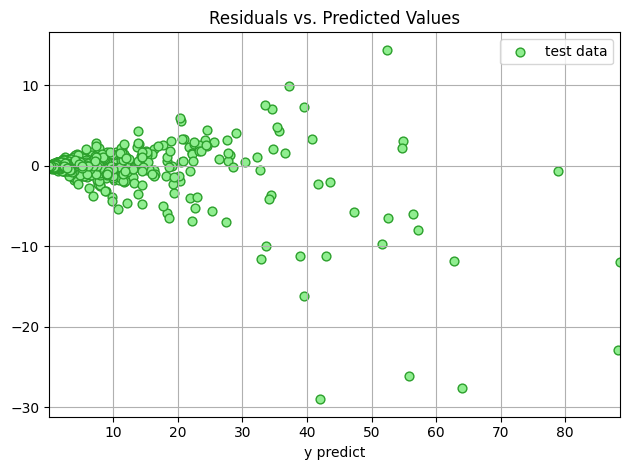

In [112]:
labels = y_test
predictions = y_pred
x_max = np.max(
    [np.max(y_pred), np.max(y_pred)]
)
x_min = np.min(
    [np.min(y_pred), np.min(y_pred)]
)

fig, axes = plt.subplots(nrows=1, ncols=1)

axes.set_title("Residuals vs. Predicted Values")
axes.scatter(y_pred, y_pred-y_test, color='lightgreen', marker='o', s=40, edgecolors='tab:green', label='test data')
axes.grid(True)
axes.set_xlabel('y predict')
axes.set_xlim([x_min, x_max])
axes.legend()

plt.tight_layout()
plt.show()

In [81]:
# modelo_dtr = DecisionTreeRegressor(
#     max_depth=20, # numero m√°ximo de niveles en cada √°rbol
#     )
# modelo.fit(x_train, y_train) # entrenar el modelo

In [82]:
# tree_scores = cross_val_score(modelo, x_train, y_train, cv=5, n_jobs=20)

# # x_train_pred = modelo_dtr.predict(x_train)
# # y_test_pred = modelo_dtr.predict(y_test)

### 4. Visualizacion del modelo

In [83]:
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test, 
    y=y_pred, 
    mode='markers', 
    name='Predicciones',
    marker=dict(color='blue', size=5)
))
fig.add_trace(go.Scatter(
    x=y_test, 
    y=y_test, 
    mode='lines', 
    name='L√≠nea de referencia',
    line=dict(color='red', width=2)
))
fig.update_layout(
    title='Predicciones vs Valores Reales',
    xaxis_title='Valores Reales (mm)',
    yaxis_title='Predicciones (mm)',
    width=800,
    height=600
)
fig.show()

In [84]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.scatter(y_test, y_pred, alpha=0.5)
# ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
# ax.set_xlabel('Valores Reales (mm)')
# ax.set_ylabel('Predicciones (mm)')
# ax.set_title('Valores Reales vs Predicciones')
# plt.grid()
# plt.tight_layout()
# plt.show()

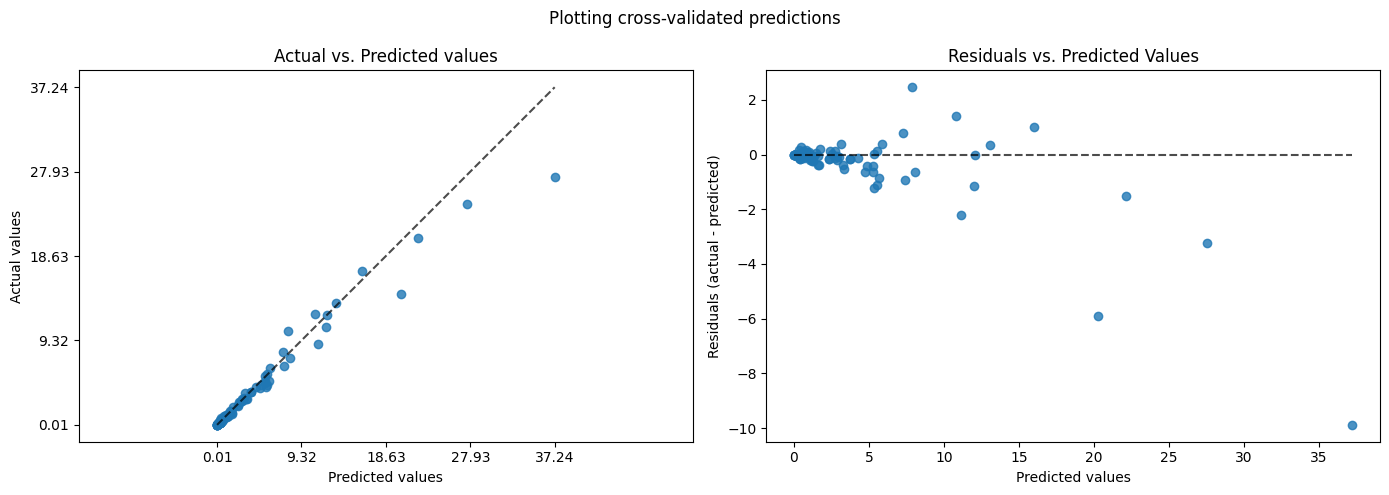

In [85]:
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

### 5. Comparativa

In [117]:
def predece_y_compara(datos_viga, modelo):
    data_in = pd.DataFrame([datos_viga])[data_keys2]

    pred_ml = modelo.predict(data_in)[0]

    # Calculo teorico
    longitud = datos_viga['L']
    carga = datos_viga['P']  # Convertir a N
    ancho_b = datos_viga['b']
    altura_h = datos_viga['h']
    E = datos_viga['E']
    I = (ancho_b * altura_h**3) / 12.0  # [m^4]
    deflexion_teorico = (carga * longitud**3) / (48 * E * I) # [mm]

    error = abs(pred_ml - deflexion_teorico)
    error_relativo = error / deflexion_teorico * 100

    print(f"C√°lculo Teorico ......: {deflexion_teorico:.2f} mm")
    print(f"C√°lculo por ML: {pred_ml:.2f} mm")
    print(f"Error: {error:.4f} ({error_relativo:.2f}%)")

    return 0


In [119]:
datos_viga = {
    "L": 2.0 * (m),
    "P": 50.0 * (kN),
    "b": 0.30 * (m),
    "h": 0.50 * (m),
    "fc": 280 * (kg/cm**2),
    "E": 24_870_000 * (m**2),
}

response = predece_y_compara(datos_viga, modelo)
response

C√°lculo Teorico ......: 0.11 mm
C√°lculo por ML: 0.20 mm
Error: 0.0912 (85.03%)


0

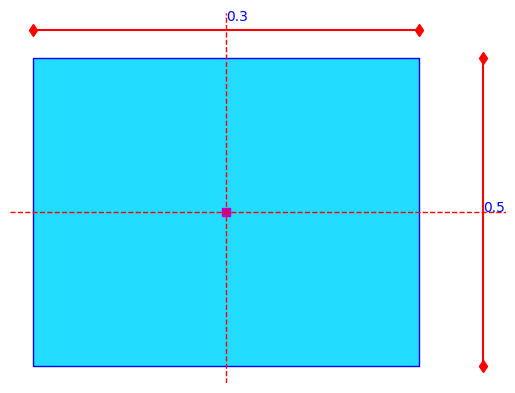

In [91]:
fig, axes = plt.subplots()
sec_rectangular(axes, datos_viga['b'], datos_viga['h'], False)
plt.axis('off')
plt.show()
plt.close()